In [29]:
import xarray as xr
import numpy as np
import sys
from glob import glob
import gc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/home/vmaithel')

g = 9.8 #[m s^-2]
L = 2.26e6 #[J/kg]
cp = 1005 #[J/kg-K]
R_e = 6.378e6 #[m]
pi = 22/7
"""
local scripts, if loading from a different directory include that with a '.' between
directory name and script name
"""
from tropical_PODs.PODs.POD_utils import limit_files_to_select_years
from tropical_PODs.PODs.POD_utils import calculate_one_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import calculate_two_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import calculate_two_variable_binned_coevolution_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_one_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_two_variable_binned_ivar_composites
from tropical_PODs.PODs.POD_utils import process_multiyear_two_variable_binned_coevolution_composites
from tropical_PODs.PODs.plotting_utils import plot_one_variable_binned_ivar
from tropical_PODs.PODs.plotting_utils import plot_two_variables_binned_ivar
from tropical_PODs.PODs.POD_utils import numerical_plume_model
from tropical_PODs.PODs.POD_utils import bin_by_two_variables

In [30]:
def load_in_data(input_file, xarray_name, start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level):
    
    paths = glob(input_file)
    year_limited_paths = limit_files_to_select_years(paths,range(start_year,end_year+1))
    dataset = xr.open_mfdataset(year_limited_paths, combine="by_coords")
    dataset = dataset.sortby('lat', ascending=True)

    if 'level' in dataset.dims:
        data_var = dataset[xarray_name].sel(time = slice(str(start_year)+'-01-01', str(end_year)+'-12-31'), lat = slice(lat_lbound,lat_ubound), level = slice(upper_level, lower_level))
    else: 
        data_var = dataset[xarray_name].sel(time = slice(str(start_year)+'-01-01', str(end_year)+'-12-31'), lat = slice(lat_lbound,lat_ubound))

    data_var.load()

    return dataset, data_var

In [31]:
# Years to analyze
start_year = (2011)
end_year = (2012)

lat_lbound = -10 
lat_ubound = 10

upper_level = 100
lower_level = 1000

################
###.  VIJIT MSE budget calculations  ###
################

input_dir = '/home/vmaithel/MSE_budgets/2p5_vijit/no_seasonality/'

input_file_MSE_tend = input_dir+'MSE_tend_ns.*.nc'  
input_file_col_MSE = input_dir+'col_MSE_ns.*.nc' 
input_file_col_VADV = input_dir+'col_VADV_ns.*.nc' 
input_file_col_HADV = input_dir+'col_HADV_ns.*.nc' 
input_file_col_HADV_zonal = input_dir+'col_HADV_zonal_ns.*.nc'  
input_file_col_HADV_meridional = input_dir+'col_HADV_meridional_ns.*.nc' 
input_file_SF = input_dir+'SF_ns.*.nc'
input_file_RadF_net = input_dir+'RadF_net_ns.*.nc'

dataset_col_MSE, col_MSE = load_in_data(input_file_col_MSE,'col_MSE_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_col_VADV, col_VADV = load_in_data(input_file_col_VADV,'col_VADV_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_col_HADV, col_HADV = load_in_data(input_file_col_HADV,'col_HADV_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_col_HADV_zonal, col_HADV_zonal = load_in_data(input_file_col_HADV_zonal,'col_HADV_zonal_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_col_HADV_meridional, col_HADV_meridional = load_in_data(input_file_col_HADV_meridional,'col_HADV_meridional_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_MSE_tend, MSE_tend = load_in_data(input_file_MSE_tend,'MSE_tend_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_SF, SF = load_in_data(input_file_SF,'SF_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
dataset_RadF_net, RadF_net = load_in_data(input_file_RadF_net,'RadF_net_ns',start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)


In [32]:
odir_datasets = '/home/vmaithel/MSE_budgets/binned_data/'

# Output directory for plots
odir_plots = '/home/vmaithel/plots/'

In [33]:
##### Load in CSF and precipitation data - precip data is only available from 2011 to 2012 for now

input_dir_CSF = '/home/vmaithel/MSE_budgets/cape_data/'

input_file_CSF = input_dir_CSF + 'CSF_*.nc'

dataset_CSF, CSF = load_in_data(input_file_CSF,'csf', start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)

input_file_precip = '/Projects/era5_regrid/IMERG/3B-DAY.MS.MRG.3IMERG.V06.*' # IMERG Precipitation'
dataset_precip, precipitation_rate = load_in_data(input_file_precip, 'precipAvg', start_year, end_year, lat_lbound, lat_ubound, upper_level, lower_level)
precipitation_rate = precipitation_rate*24 #convert from mm/hr to mm/day
precipitation_rate = precipitation_rate.resample(time='1D').mean('time')

precipitation_rate['time'] = precipitation_rate.indexes['time'].to_datetimeindex() # IMERG time was saved as CFtime, and we need to convert to datetime for xarray

print(CSF)

<xarray.DataArray 'csf' (time: 731, lat: 9, lon: 144)>
array([[[0.55536795, 0.55868512, 0.57889443, ..., 0.57827434,
         0.57495005, 0.56478288],
        [0.60349445, 0.66008956, 0.72176926, ..., 0.53041868,
         0.55104853, 0.584034  ],
        [0.73364422, 0.75968439, 0.80600866, ..., 0.62044891,
         0.6617205 , 0.69650818],
        ...,
        [0.45976665, 0.38566948, 0.42703561, ..., 0.65814332,
         0.62730826, 0.63194551],
        [0.31568606, 0.27906125, 0.2772331 , ..., 0.3886186 ,
         0.30302713, 0.34493298],
        [0.20625171, 0.25595976, 0.26239359, ..., 0.23095461,
         0.21009643, 0.17834071]],

       [[0.5427536 , 0.52704071, 0.5684611 , ..., 0.55531851,
         0.54357632, 0.54388825],
        [0.60442344, 0.64300509, 0.70811116, ..., 0.51648871,
         0.53812722, 0.57791864],
        [0.73832009, 0.7544087 , 0.77167925, ..., 0.6314039 ,
         0.66781947, 0.71641053],
...
        [0.61572661, 0.53229907, 0.54494206, ..., 0.60746431,


/tmp/ipykernel_4106028/2807171514.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  precipitation_rate['time'] = precipitation_rate.indexes['time'].to_datetimeindex() # IMERG time was saved as CFtime, and we need to convert to datetime for xarray


In [34]:
#### ensure that xarray coordinates are consistent across all variables. Minor differences can lead to errors in the binning process

#### Radiative and surface flux xarrays are also at a different time

full_lat = MSE_tend.lat
full_lon = MSE_tend.lon
full_time = MSE_tend.time

base_coords = MSE_tend.coords
base_dims = MSE_tend.dims


CSF = xr.DataArray(CSF, dims= base_dims, coords = base_coords)
precipitation_rate = xr.DataArray(precipitation_rate, dims= base_dims, coords = base_coords)

RadF_net = xr.DataArray(RadF_net,dims = base_dims, coords = base_coords)
SF = xr.DataArray(SF,dims = base_dims, coords = base_coords)


In [35]:
#### Applying land mask

# Land
ifile_land_frac = '/Projects/era5_regrid/2p5_vijit/ERAi_landfrac_2p5.nc' # ERAi Land Fraction

dataset_land = xr.open_dataset(ifile_land_frac)
landfrac = dataset_land['landfrac']
landfrac.load()
landfrac = landfrac.sortby('lat', ascending=True) # Re-order lat to match code for other datasets

landfrac = landfrac.sel(lat = slice(lat_lbound, lat_ubound)) 

# Create ocean mask #

is_valid_ocean_mask = (landfrac < 0.1)

precipitation_rate = precipitation_rate.where(is_valid_ocean_mask, other = np.nan)

CSF = CSF.where(is_valid_ocean_mask, other = np.nan)

col_VADV = col_VADV.where(is_valid_ocean_mask, other = np.nan)

col_HADV = col_HADV.where(is_valid_ocean_mask, other = np.nan)

MSE_tend = MSE_tend.where(is_valid_ocean_mask, other = np.nan)

col_HADV_zonal = col_HADV_zonal.where(is_valid_ocean_mask, other = np.nan)

col_HADV_meridional = col_HADV_meridional.where(is_valid_ocean_mask, other = np.nan)

SF = SF.where(is_valid_ocean_mask, other = np.nan)

RadF_net = RadF_net.where(is_valid_ocean_mask, other = np.nan)


In [36]:
########################################################################
###  Calculate CSF + Log Precipitation Composites  ####
########################################################################

print('Starting CSF + Log Precipitation Composites')

for year in range(start_year, end_year+1):

    ### Define binning parameters ###

    log_space = np.logspace(-4,3,num=29)
        
    BV1 = CSF.sel(time = str(year))
        
    BV1_name_str = 'CSF'
        
    BV1_units_str = '[Kg Kg^-1]'
        
    lower_BV1_bin_limit_vector = np.arange(0.0, 0.95 + 0.05, 0.05) # CSF

    upper_BV1_bin_limit_vector = np.arange(0.05, 1 + 0.05, 0.05) # CSF
    
    BV2 = precipitation_rate.sel(time = str(year))
        
    BV2_name_str = 'precipitation_rate'
        
    BV2_units_str = '[mm day^-1]'

    lower_BV2_bin_limit_vector = log_space[0 : -1] # Precipitation rate

    upper_BV2_bin_limit_vector = log_space[1 :] # Precipitation rate
        
    log_bins_boolean = True

    fname_datasets = odir_datasets

    calculate_two_variable_binned_coevolution_composites(BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)


    #Data to be binned - just change below this for changing to different budget terms

    # MSE tendency
    ivar = MSE_tend.sel(time = str(year))

    ivar_name_str = 'col_MSE_tendency'
    print(ivar_name_str)
    ivar_units_str = '[W m^-2]'

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    # Column Vertical advectuon
    ivar = col_VADV.sel(time = str(year))

    ivar_name_str = 'col_VADV'
    print(ivar_name_str)
    ivar_units_str = '[W m^-2]'

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)

    # column horizontal advection
    ivar = col_HADV.sel(time = str(year))

    ivar_name_str = 'col_HADV'
    print(ivar_name_str)
    ivar_units_str = '[W m^-2]'

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)


    # col radiative fluxes
    ivar = RadF_net.sel(time = str(year))

    ivar_name_str = 'RadF_net'
    print(ivar_name_str)
    ivar_units_str = '[W m^-2]'

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)


    # Surface fluxes
    ivar = SF.sel(time = str(year))

    ivar_name_str = 'SF'
    print(ivar_name_str)
    ivar_units_str = '[W m^-2]'

    calculate_two_variable_binned_ivar_composites(ivar, BV1, BV2, lower_BV1_bin_limit_vector, upper_BV1_bin_limit_vector, lower_BV2_bin_limit_vector, upper_BV2_bin_limit_vector, ivar_name_str, ivar_units_str, BV1_name_str, BV1_units_str, BV2_name_str, BV2_units_str, year, fname_datasets, log_bins_boolean)


Starting CSF + Log Precipitation Composites
Calculating Differences
Binning and Compositing
col_MSE_tendency
Calculating Differences
Binning and Compositing
col_VADV
Calculating Differences
Binning and Compositing
col_HADV
Calculating Differences
Binning and Compositing
RadF_net
Calculating Differences
Binning and Compositing
SF
Calculating Differences
Binning and Compositing
Calculating Differences
Binning and Compositing
col_MSE_tendency
Calculating Differences
Binning and Compositing
col_VADV
Calculating Differences
Binning and Compositing
col_HADV
Calculating Differences
Binning and Compositing
RadF_net
Calculating Differences
Binning and Compositing
SF
Calculating Differences
Binning and Compositing


### Driver for plotting

In [37]:
# Define colormap # 

colors = [(10, 50, 120), (15, 75, 165), (30, 110, 200), (60, 160, 240), (80, 180, 250), (130, 210, 255), (160, 240, 255), (200, 250, 255), (230, 255, 255), (230, 230, 230), (230, 230, 230), (255, 250, 220), (255, 232, 120), (255, 192, 60), (255, 160, 0), (255, 96, 0), (255, 50, 0), (225, 20, 0), (192, 0, 0), (165, 0, 0)]
for list_index in range(len(colors)):
    colors[list_index] = tuple(tuple_element/255. for tuple_element in colors[list_index])
        
n_bin = 200
cmap_name = 'colors'
colormap_colors = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

### Define plotting parameters ###

min_number_of_obs = 200

years_to_plot_list = list(range(2011,2013))

print(years_to_plot_list)

[2011, 2012]


### Plotting - 

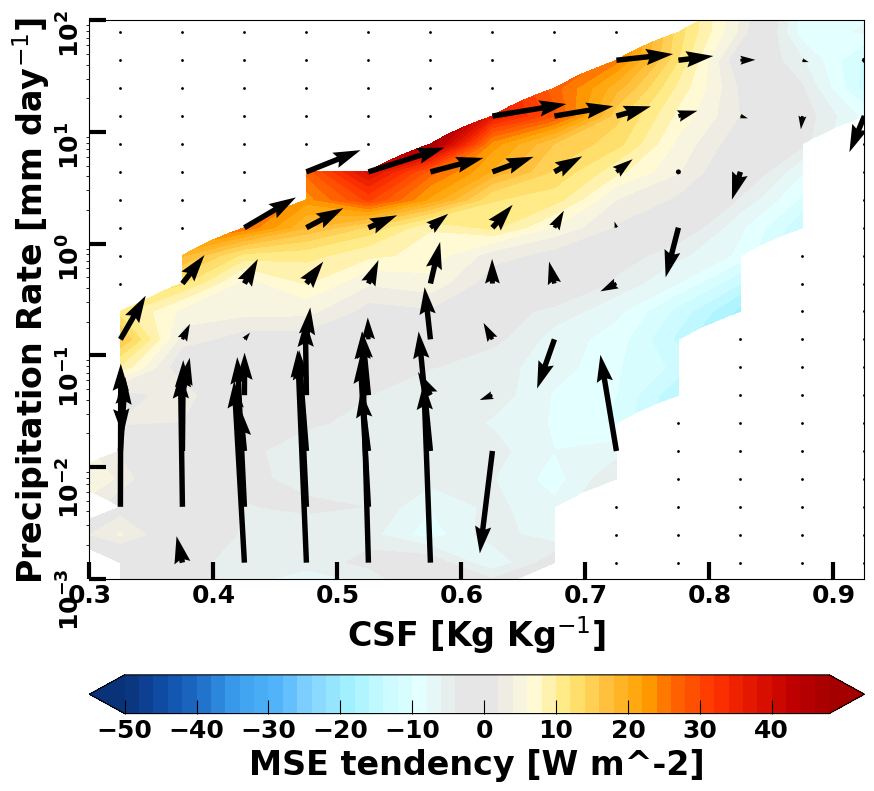

In [38]:
### MSE tendency composites

CSF_precipitation_rate_log_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_coevolution_composite_*'), years_to_plot_list))
CSF_precipitation_rate_log_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_col_MSE_tendency_composite_*'), years_to_plot_list))

two_variable_binned_coevolution_composites = CSF_precipitation_rate_log_binned_coevolution_composite
x_axis_limits = (0.3, 0.925)
y_axis_limits = (10**-3, 10**2)
x_axis_label = 'CSF [Kg Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = True
color_shading_var = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_mean_ivar'] 
color_shading_var_number_of_samples = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(-50, 50, 2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-50, 50, 10)
colorbar_label_string = 'MSE tendency [W m^-2]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CSF_precipitation_rate_log_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)


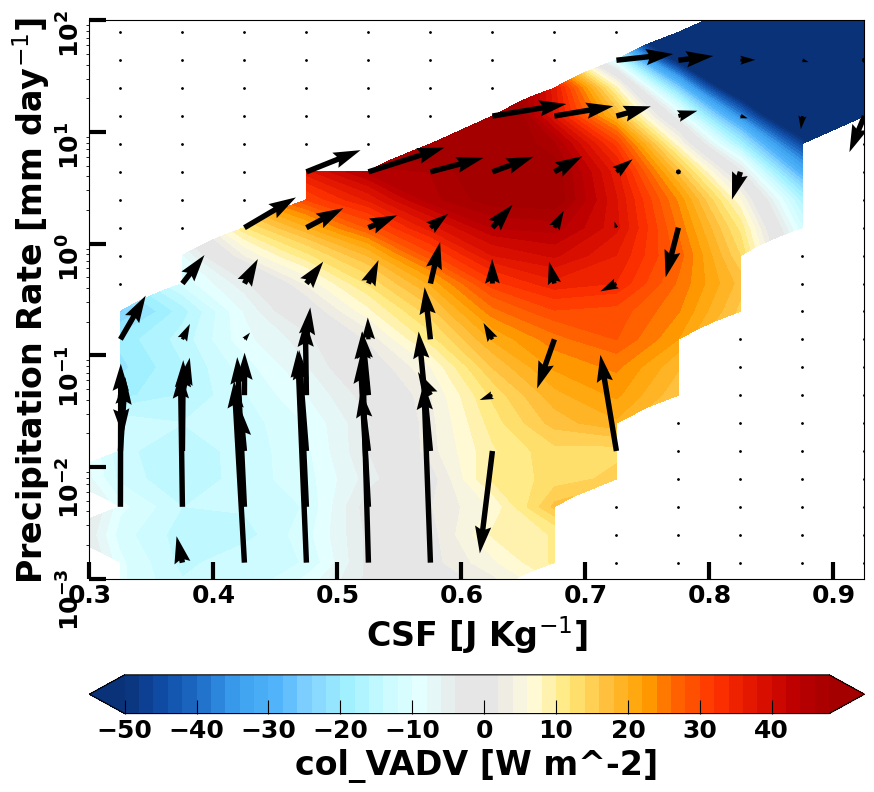

In [39]:
### Vertical MSE advection composite

#CSF_precipitation_rate_log_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_coevolution_composite_*'), years_to_plot_list))
CSF_precipitation_rate_log_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_col_VADV_composite_*'), years_to_plot_list))

two_variable_binned_coevolution_composites = CSF_precipitation_rate_log_binned_coevolution_composite
x_axis_limits = (0.3, 0.925)
y_axis_limits = (10**-3, 10**2)
x_axis_label = 'CSF [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = True
color_shading_var = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_mean_ivar'] 
color_shading_var_number_of_samples = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(-50, 50, 2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-50, 50, 10)
colorbar_label_string = 'col_VADV [W m^-2]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CSF_precipitation_rate_log_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)


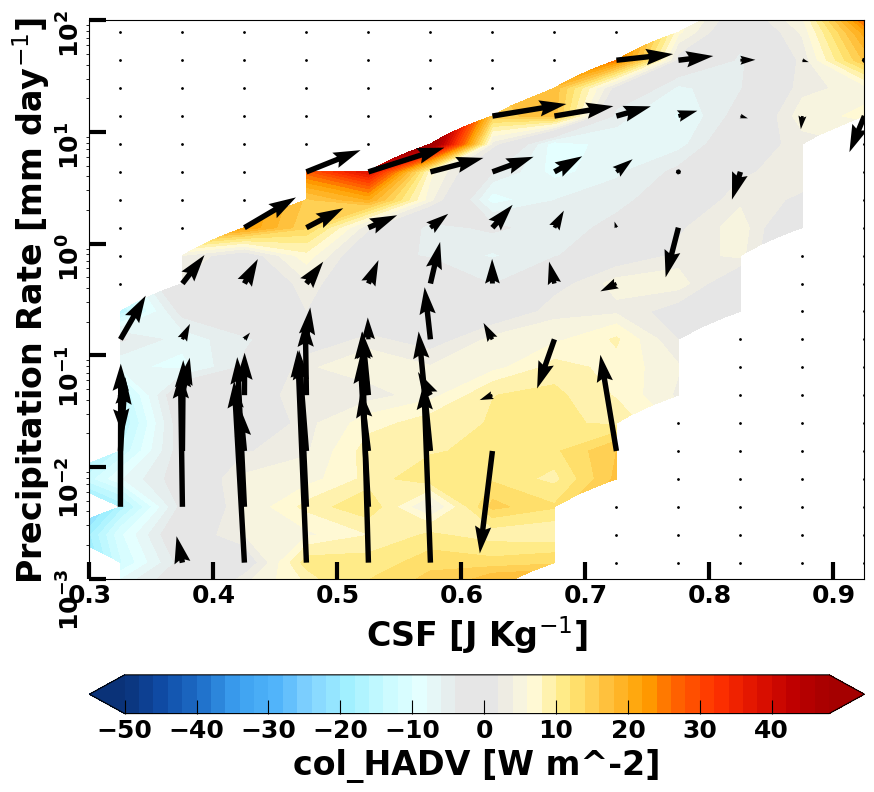

In [40]:
### Horizontal MSE advection composite

#CSF_precipitation_rate_log_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_coevolution_composite_*'), years_to_plot_list))
CSF_precipitation_rate_log_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_col_HADV_composite_*'), years_to_plot_list))

two_variable_binned_coevolution_composites = CSF_precipitation_rate_log_binned_coevolution_composite
x_axis_limits = (0.3, 0.925)
y_axis_limits = (10**-3, 10**2)
x_axis_label = 'CSF [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = True
color_shading_var = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_mean_ivar'] 
color_shading_var_number_of_samples = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(-50, 50, 2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-50, 50, 10)
colorbar_label_string = 'col_HADV [W m^-2]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CSF_precipitation_rate_log_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)


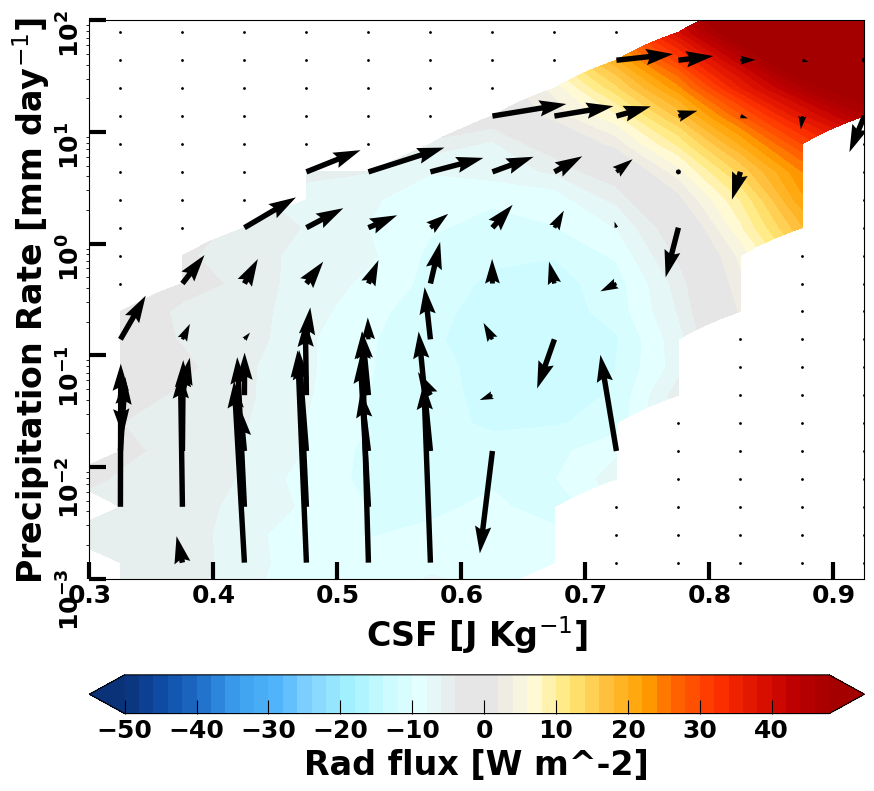

In [41]:
### Radiative fluxes

#CSF_precipitation_rate_log_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_coevolution_composite_*'), years_to_plot_list))
CSF_precipitation_rate_log_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_RadF_net_composite_*'), years_to_plot_list))

two_variable_binned_coevolution_composites = CSF_precipitation_rate_log_binned_coevolution_composite
x_axis_limits = (0.3, 0.925)
y_axis_limits = (10**-3, 10**2)
x_axis_label = 'CSF [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = True
color_shading_var = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_mean_ivar'] 
color_shading_var_number_of_samples = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(-50, 50, 2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-50, 50, 10)
colorbar_label_string = 'Rad flux [W m^-2]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CSF_precipitation_rate_log_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)


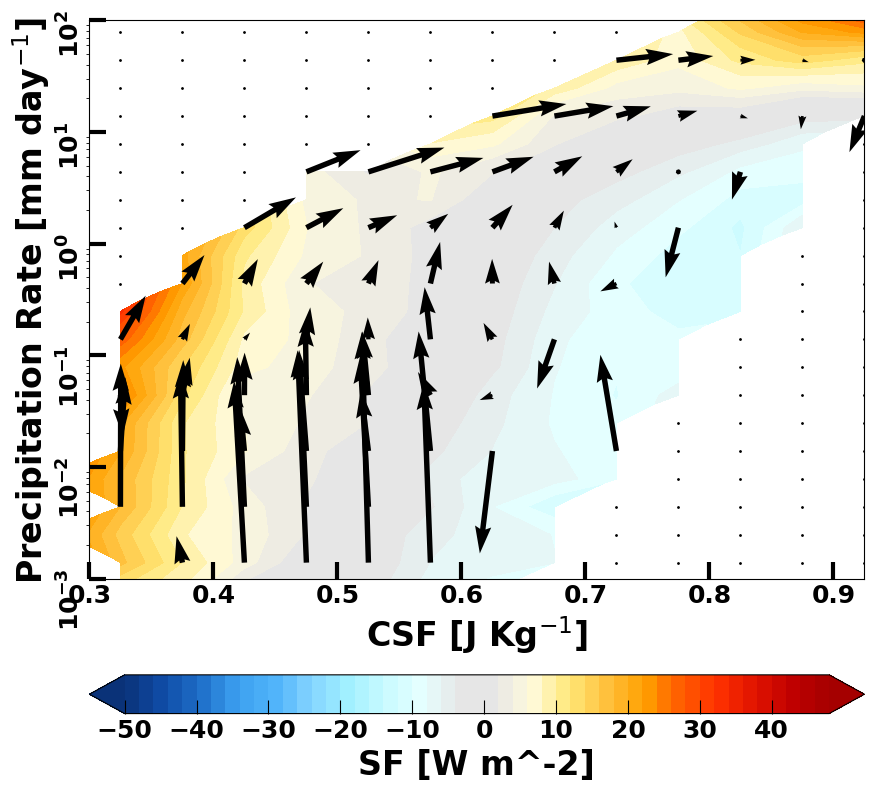

In [42]:
### Surface flux composites

#CSF_precipitation_rate_log_binned_coevolution_composite = process_multiyear_two_variable_binned_coevolution_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_coevolution_composite_*'), years_to_plot_list))
CSF_precipitation_rate_log_binned_precipitation_rate_composite = process_multiyear_two_variable_binned_ivar_composites(limit_files_to_select_years(glob(odir_datasets + 'CSF_precipitation_rate_log_binned_SF_composite_*'), years_to_plot_list))

two_variable_binned_coevolution_composites = CSF_precipitation_rate_log_binned_coevolution_composite
x_axis_limits = (0.3, 0.925)
y_axis_limits = (10**-3, 10**2)
x_axis_label = 'CSF [J Kg$^{-1}$]'
y_axis_label = 'Precipitation Rate [mm day$^{-1}$]'
pdf_axis_label='Percent of Total Samples'
log_Y_axis_boolean = True
color_shading_var = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_mean_ivar'] 
color_shading_var_number_of_samples = CSF_precipitation_rate_log_binned_precipitation_rate_composite['bin_number_of_samples_centered']
color_shading_levels = np.arange(-50, 50, 2)
color_shading_map = colormap_colors
colorbar_extend_string = 'both'
colorbar_tick_levels = np.arange(-50, 50, 10)
colorbar_label_string = 'SF [W m^-2]'
scientific_colorbar_boolean = False
plot_vectors_boolean = True
leading_lagging_centered_string='centered'
save_fig_boolean = False
figure_path_and_name = odir_plots + 'CSF_precipitation_rate_log_binned_precipitation_rate_composite_' + str(years_to_plot_list[0]) + '_' + str(years_to_plot_list[-1]) + '.png'

plot_two_variables_binned_ivar(two_variable_binned_coevolution_composites, color_shading_var, color_shading_var_number_of_samples, min_number_of_obs, color_shading_levels, color_shading_map, colorbar_extend_string, colorbar_tick_levels, colorbar_label_string, scientific_colorbar_boolean, log_Y_axis_boolean, x_axis_limits, y_axis_limits, x_axis_label, y_axis_label, plot_vectors_boolean, leading_lagging_centered_string, save_fig_boolean, figure_path_and_name)
